## **disaster image classification training**


In [7]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import logging




In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
'''

import zipfile
import os

# Path to your uploaded ZIP in Google Drive
#zip_path = "/content/drive/MyDrive/disaster_classification.zip"

# Where to unzip
extract_path = "/content/drive/MyDrive/disaster_classification"

# Unzip only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Unzipped contents:", os.listdir(extract_path))


'''


'\n\nimport zipfile\nimport os\n\n# Path to your uploaded ZIP in Google Drive\n#zip_path = "/content/drive/MyDrive/disaster_classification.zip"\n\n# Where to unzip\nextract_path = "/content/drive/MyDrive/disaster_classification"\n\n# Unzip only if not already extracted\nif not os.path.exists(extract_path):\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n\nprint("Unzipped contents:", os.listdir(extract_path))\n\n\n'

In [11]:


BASE_DIR = "/content/drive/MyDrive/disaster_classification"

IMAGE_DIR = os.path.join(BASE_DIR, "ASONAM17_Damage_Image_Dataset")
TRAIN_TSV = os.path.join(BASE_DIR, "ASONAM_train.tsv")
DEV_TSV   = os.path.join(BASE_DIR, "ASONAM_dev.tsv")
TEST_TSV  = os.path.join(BASE_DIR, "ASONAM_test.tsv")

print("Checking files exist:")
print("Train:", os.path.exists(TRAIN_TSV))
print("Dev:", os.path.exists(DEV_TSV))
print("Test:", os.path.exists(TEST_TSV))
print("Images folder:", os.path.exists(IMAGE_DIR))


Checking files exist:
Train: True
Dev: True
Test: True
Images folder: True


In [12]:
import os
import pandas as pd

dataset_root = "/content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset"

# Mapping: which TSV corresponds to which split
tsv_mapping = {
    "ASONAM_train.tsv": "train",
    "ASONAM_dev.tsv": "dev",
    "ASONAM_test.tsv": "test"
}

base_dir = "/content/drive/MyDrive/disaster_classification"

# Function to detect class folder from filename
def get_class_from_filename(fname):
    fname = fname.lower()
    if "_mild_" in fname:
        return "mild"
    elif "_severe_" in fname:
        return "severe"
    elif "_none_" in fname:
        return "none"
    else:
        return "unknown"

for tsv_file, split_folder in tsv_mapping.items():
    tsv_path = os.path.join(base_dir, tsv_file)
    df = pd.read_csv(tsv_path, sep="\t")

    new_paths = []
    for old_path in df["image_path"]:
        fname = os.path.basename(old_path)             # get filename only
        class_folder = get_class_from_filename(fname)  # detect mild/none/severe
        new_path = os.path.join(dataset_root, split_folder, class_folder, fname)
        new_paths.append(new_path)

    df["image_path"] = new_paths

    # 🔹 Drop unknown and non-existent paths
    df = df[~df["image_path"].str.contains("/unknown/")]
    df = df[df["image_path"].apply(lambda x: os.path.exists(x))]

    # Save cleaned TSV
    df.to_csv(tsv_path, sep="\t", index=False)
    print(f"✅ Cleaned {tsv_file}, remaining rows: {len(df)}")

    # --- Sanity check: print first 5 ---
    print(f"\n🔍 Sanity check for {tsv_file}:")
    for sample in df["image_path"].head(5):
        print("Path:", sample, "| Exists:", os.path.exists(sample))
    print("-" * 50)

print("🎯 Done fixing + cleaning all TSVs!")


✅ Cleaned ASONAM_train.tsv, remaining rows: 15662

🔍 Sanity check for ASONAM_train.tsv:
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/severe/ecuador_eq_severe_im_645.jpg | Exists: True
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/severe/ecuador_eq_severe_im_1378.jpg | Exists: True
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/mild/ecuador_eq_mild_im_2573.jpg | Exists: True
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/mild/ecuador_eq_mild_im_1792.jpg | Exists: True
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/none/ecuador_eq_none_im_2486.jpg | Exists: True
--------------------------------------------------
✅ Cleaned ASONAM_dev.tsv, remaining rows: 1404

🔍 Sanity check for ASONAM_dev.tsv:
Path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/dev

In [13]:
df = pd.read_csv("/content/drive/MyDrive/disaster_classification/ASONAM_train.tsv", sep="\t")
sample_path = df.iloc[0]["image_path"]
print("Sample fixed path:", sample_path)
print("Exists:", os.path.exists(sample_path))


Sample fixed path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/severe/ecuador_eq_severe_im_645.jpg
Exists: True


In [14]:


# Look at the first few folders
print("Top level:", os.listdir("/content/drive/MyDrive/disaster_classification")[:10])

# Look inside for ASONAM folder
asonam_path = "/content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset"
if os.path.exists(asonam_path):
    print("ASONAM dataset folders:", os.listdir(asonam_path)[:10])
else:
    print("❌ ASONAM folder not found at expected path")


Top level: ['ASONAM17_Damage_Image_Dataset', 'checkpoint_epoch1.pth', 'checkpoint_epoch2.pth', 'checkpoint_epoch3.pth', 'checkpoint_epoch4.pth', 'checkpoint_epoch5.pth', 'checkpoint_epoch6.pth', 'checkpoint_epoch7.pth', 'checkpoint_epoch8.pth', 'model_best.pth']
ASONAM dataset folders: ['dev', 'test', 'train']


In [15]:


# Load TSVs
train_df = pd.read_csv(TRAIN_TSV, sep="\t")
dev_df   = pd.read_csv(DEV_TSV, sep="\t")
test_df  = pd.read_csv(TEST_TSV, sep="\t")

print("Train shape:", train_df.shape)
print("Dev shape:", dev_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain sample:")
print(train_df.head())


print("Unique disaster types:", df['disaster_types'].unique())
print("Number of classes:", df['disaster_types'].nunique())


Train shape: (15662, 7)
Dev shape: (1404, 7)
Test shape: (2821, 7)

Train sample:
     image_id                     event_name  \
0  ASONAM2017   ecuador_eq_severe_im_645.jpg   
1  ASONAM2017  ecuador_eq_severe_im_1378.jpg   
2  ASONAM2017    ecuador_eq_mild_im_2573.jpg   
3  ASONAM2017    ecuador_eq_mild_im_1792.jpg   
4  ASONAM2017    ecuador_eq_none_im_2486.jpg   

                                          image_path damage_severity  \
0  /content/drive/MyDrive/disaster_classification...          severe   
1  /content/drive/MyDrive/disaster_classification...          severe   
2  /content/drive/MyDrive/disaster_classification...            mild   
3  /content/drive/MyDrive/disaster_classification...            mild   
4  /content/drive/MyDrive/disaster_classification...  little_or_none   

   informative                       humanitarian  disaster_types  
0  informative  infrastructure_and_utility_damage      earthquake  
1  informative  infrastructure_and_utility_damage      earth

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15662 entries, 0 to 15661
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_id         15662 non-null  object
 1   event_name       15662 non-null  object
 2   image_path       15662 non-null  object
 3   damage_severity  15662 non-null  object
 4   informative      15662 non-null  object
 5   humanitarian     15662 non-null  object
 6   disaster_types   15662 non-null  object
dtypes: object(7)
memory usage: 856.6+ KB


In [17]:
# -------------------------
# Logging setup
# -------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# -------------------------
# Load data and filter ASONAM17 subset
# -------------------------
train_df = pd.read_csv(TRAIN_TSV, sep="\t")
dev_df   = pd.read_csv(DEV_TSV, sep="\t")
test_df  = pd.read_csv(TEST_TSV, sep="\t")

# Keep only ASONAM17 rows
train_asonam = train_df[train_df["image_path"].str.contains("ASONAM17_Damage_Image_Dataset", na=False)]
dev_asonam   = dev_df[dev_df["image_path"].str.contains("ASONAM17_Damage_Image_Dataset", na=False)]
test_asonam  = test_df[test_df["image_path"].str.contains("ASONAM17_Damage_Image_Dataset", na=False)]

# Drop rows with missing labels
target_col = "disaster_types"   # <-- correct column name
train_asonam = train_asonam.dropna(subset=[target_col])
dev_asonam   = dev_asonam.dropna(subset=[target_col])
test_asonam  = test_asonam.dropna(subset=[target_col])

# Save new filtered TSVs
train_asonam.to_csv("ASONAM_train.tsv", sep="\t", index=False)
dev_asonam.to_csv("ASONAM_dev.tsv", sep="\t", index=False)
test_asonam.to_csv("ASONAM_test.tsv", sep="\t", index=False)

# -------------------------
# Log dataset stats
# -------------------------
logging.info(f"Train size: {len(train_asonam)}, Dev size: {len(dev_asonam)}, Test size: {len(test_asonam)}")
logging.info(f"Train distribution:\n{train_asonam[target_col].value_counts()}")




In [18]:
# -------------------------
# Label mapping
# -------------------------
labels = sorted(train_df[target_col].unique())
label_to_idx = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels)


logging.info(f"Number of classes: {num_classes}")

In [20]:


logging.info(f"Train size: {len(train_df)}, Dev size: {len(dev_df)}, Test size: {len(test_df)}")
logging.info(f"Train distribution:\n{train_df[target_col].value_counts()}")


# -------------------------
# Label mapping
# -------------------------
labels = sorted(train_df[target_col].unique())
label_to_idx = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels)


logging.info(f"Number of classes: {num_classes}")


# -------------------------
# Dataset class
# -------------------------
class MEDICDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_path"])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            logging.warning(f"Failed to load image {img_path}, returning zeros")
            image = Image.fromarray(np.zeros((224,224,3), dtype=np.uint8))


        if self.transform:
            image = self.transform(image)


        label = label_to_idx[row[target_col]]
        return image, label

In [ ]:
# -------------------------
# Transforms
# -------------------------
data_transforms = {
'train': transforms.Compose([
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
}


IMAGE_DIR = "images" # adjust if needed


train_dataset = MEDICDataset(train_df, IMAGE_DIR, data_transforms['train'])
dev_dataset = MEDICDataset(dev_df, IMAGE_DIR, data_transforms['val'])
test_dataset = MEDICDataset(test_df, IMAGE_DIR, data_transforms['test'])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace final layer (ResNet18 has 512 features before final FC)
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]


NameError: name 'device' is not defined

Sample path: /content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/train/severe/ecuador_eq_severe_im_645.jpg
Exists: True
✅ Image loaded successfully!


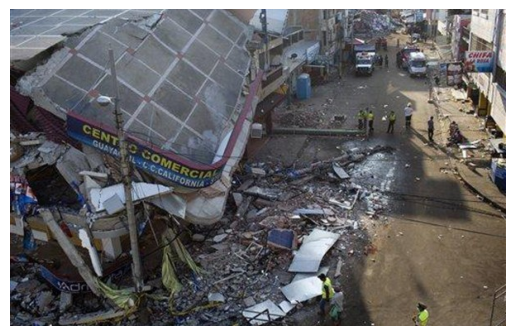

In [21]:
import pandas as pd
from PIL import Image
import os

# Load the fixed train TSV
df = pd.read_csv("/content/drive/MyDrive/disaster_classification/ASONAM_train.tsv", sep="\t")

# Pick the first image path
sample_path = df.iloc[0]["image_path"]
print("Sample path:", sample_path)
print("Exists:", os.path.exists(sample_path))

# Try to open the image
try:
    img = Image.open(sample_path)
    img.show()  # works in local Jupyter
    print("✅ Image loaded successfully!")
except Exception as e:
    print("❌ Failed to load image:", e)
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")
plt.show()


In [22]:
# ----------------- Paste THIS whole cell into Colab -----------------
import os, time, torch, logging
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.optim as optim

# ====== USER CONFIG - EDIT ======
OUT_DIR = "/content/drive/MyDrive/disaster_classification"  # change to your Drive folder
NUM_CLASSES = 7          # change if different
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESUME_CHECKPOINT = None  # set path to checkpoint to resume (optional), e.g. "/content/drive/.../checkpoint_epoch3.pth"
# =================================

os.makedirs(OUT_DIR, exist_ok=True)

In [23]:
# ---------------- checkpoint helpers ----------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, best_metric, out_dir=OUT_DIR):
    ensure_dir(out_dir)
    ckpt = {
        'epoch': int(epoch),
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict() if optimizer is not None else None,
        'best_metric': float(best_metric)
    }
    tmp = os.path.join(out_dir, f"tmp_checkpoint_epoch{epoch}.pth")
    final = os.path.join(out_dir, f"checkpoint_epoch{epoch}.pth")
    torch.save(ckpt, tmp)
    os.replace(tmp, final)
    # weights-only latest
    torch.save(model.state_dict(), os.path.join(out_dir, "model_latest.pth"))
    print(f"[Checkpoint] saved epoch={epoch} -> {final}")
    return final

def save_best_weights(model, out_dir=OUT_DIR):
    ensure_dir(out_dir)
    best_path = os.path.join(out_dir, "model_best.pth")
    torch.save(model.state_dict(), best_path)
    print(f"[Best] model_best.pth saved -> {best_path}")
    return best_path

def load_checkpoint(path, model, optimizer=None, device=DEVICE):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")
    ckpt = torch.load(path, map_location=torch.device(device))
    model.load_state_dict(ckpt['model_state_dict'])
    start_epoch = int(ckpt.get('epoch', 0)) + 1
    best_metric = float(ckpt.get('best_metric', 0.0))
    if optimizer is not None and ckpt.get('optim_state_dict') is not None:
        try:
            optimizer.load_state_dict(ckpt['optim_state_dict'])
        except Exception as e:
            print("[Warning] Could not load optimizer state (incompatible). Continuing without optimizer state. Error:", e)
    print(f"[Resume] Loaded checkpoint '{path}' -> starting at epoch {start_epoch} (best_metric={best_metric})")
    return start_epoch, best_metric


In [ ]:



# ---------------- compute class weights (robust) ----------------
weights_tensor = None
try:
    # try ImageFolder style dataset targets
    if 'train_loader' in globals() and hasattr(train_loader.dataset, 'targets'):
        targets = train_loader.dataset.targets
        s = pd.Series(targets)
        counts = s.value_counts().sort_index()
        weights = [1.0 / counts.get(i, 1.0) for i in range(NUM_CLASSES)]
        weights_tensor = torch.tensor(weights, dtype=torch.float).to(DEVICE)
    else:
        # fallback to train_df if present
        if 'train_df' in globals() and 'target_col' in globals():
            counts = train_df[target_col].value_counts().sort_index()
            weights = [1.0 / counts.get(label, 1.0) for label in range(NUM_CLASSES)]
            weights_tensor = torch.tensor(weights, dtype=torch.float).to(DEVICE)
except Exception as e:
    print("Could not compute class weights automatically:", e)
    weights_tensor = None

if weights_tensor is not None:
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    print("Using weighted CrossEntropyLoss with weights:", weights_tensor.cpu().numpy())
else:
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted CrossEntropyLoss")

# ---------------- optimizer, scheduler ----------------
optimizer = optim.AdamW(model.parameters(), lr=LR)
# If you already have scheduler defined (StepLR), keep using it; else create one:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# ---------------- resume if requested ----------------
start_epoch = 1
best_val_f1 = 0.0
if RESUME_CHECKPOINT:
    start_epoch, best_val_f1 = load_checkpoint(RESUME_CHECKPOINT, model, optimizer, device=DEVICE)




Using weighted CrossEntropyLoss with weights: [0.00012243 0.01123596 0.00425532 0.00175131 0.01388889 0.0001763
 0.00116959]


/tmp/ipython-input-2392394925.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = [1.0 / counts.get(label, 1.0) for label in range(NUM_CLASSES)]


In [ ]:
# ---------------- training loop with mixed precision and checkpointing ----------------
scaler = GradScaler() if DEVICE == "cuda" else None
log_rows = []

print("Starting training on device:", DEVICE)
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    t0 = time.time()
    model.train()
    train_losses = []
    all_preds = []
    all_labels = []

    for batch in train_loader:
        # adapt depending on your dataloader output (image, label) vs dict
        images, labels = batch[0], batch[1]
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        if scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

    # train metrics
    train_preds = np.concatenate(all_preds)
    train_labels = np.concatenate(all_labels)
    train_loss = np.mean(train_losses)
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='macro')

    # validation
    model.eval()
    val_losses = []
    v_preds = []
    v_labels = []
    with torch.no_grad():
        for batch in dev_loader:
            images, labels = batch[0], batch[1]
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # inference - mixed precision not needed for eval but autocast is fine
            if scaler is not None:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_losses.append(loss.item())
            v_preds.append(outputs.argmax(dim=1).cpu().numpy())
            v_labels.append(labels.cpu().numpy())

    val_preds = np.concatenate(v_preds)
    val_labels = np.concatenate(v_labels)
    val_loss = np.mean(val_losses)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # scheduler step (per epoch)
    try:
        scheduler.step()
    except Exception:
        pass

    # checkpointing: save every epoch and save best weights on improvement
    save_checkpoint(epoch, model, optimizer, best_val_f1, OUT_DIR)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_best_weights(model, OUT_DIR)

    t1 = time.time()
    epoch_time = t1 - t0

    # logging
    row = {
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "epoch_time_s": epoch_time
    }
    log_rows.append(row)
    print(f"Epoch {epoch}/{NUM_EPOCHS} | tr_loss {train_loss:.4f} tr_f1 {train_f1:.4f} | val_loss {val_loss:.4f} val_f1 {val_f1:.4f} | time {epoch_time:.1f}s")

# save training log csv
df_log = pd.DataFrame(log_rows)
df_log.to_csv(os.path.join(OUT_DIR, "training_log.csv"), index=False)
print("Training finished. Best val F1:", best_val_f1)
print("Checkpoints and logs written to:", OUT_DIR)
# ----------------- end cell -----------------

Starting training on device: cuda


/tmp/ipython-input-2074610608.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if DEVICE == "cuda" else None
/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=1 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch1.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 1/10 | tr_loss 1.5385 tr_f1 0.2944 | val_loss 1.6061 val_f1 0.3168 | time 5578.2s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=2 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch2.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 2/10 | tr_loss 1.3400 tr_f1 0.3379 | val_loss 1.4336 val_f1 0.3808 | time 191.5s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=3 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch3.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 3/10 | tr_loss 1.2242 tr_f1 0.3622 | val_loss 1.4271 val_f1 0.3905 | time 190.5s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=4 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch4.pth
Epoch 4/10 | tr_loss 1.2234 tr_f1 0.3574 | val_loss 1.4758 val_f1 0.3668 | time 192.5s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=5 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch5.pth
Epoch 5/10 | tr_loss 1.1548 tr_f1 0.3829 | val_loss 1.4538 val_f1 0.3409 | time 192.1s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=6 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch6.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 6/10 | tr_loss 1.0313 tr_f1 0.4069 | val_loss 1.2751 val_f1 0.4172 | time 188.1s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=7 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch7.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 7/10 | tr_loss 0.9720 tr_f1 0.4384 | val_loss 1.2918 val_f1 0.4255 | time 195.5s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=8 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch8.pth
[Best] model_best.pth saved -> /content/drive/MyDrive/disaster_classification/model_best.pth
Epoch 8/10 | tr_loss 0.9333 tr_f1 0.4468 | val_loss 1.3101 val_f1 0.4605 | time 192.0s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=9 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch9.pth
Epoch 9/10 | tr_loss 0.8993 tr_f1 0.4517 | val_loss 1.3443 val_f1 0.4479 | time 191.8s


/tmp/ipython-input-2074610608.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2074610608.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Checkpoint] saved epoch=10 -> /content/drive/MyDrive/disaster_classification/checkpoint_epoch10.pth
Epoch 10/10 | tr_loss 0.8763 tr_f1 0.4583 | val_loss 1.3826 val_f1 0.4540 | time 187.5s
Training finished. Best val F1: 0.4605390187242143
Checkpoints and logs written to: /content/drive/MyDrive/disaster_classification


training completed


In [24]:
import os, shutil

# Original dataset path
SRC_DIR = "/content/drive/MyDrive/disaster_classification/ASONAM17_Damage_Image_Dataset/dev"
# New reorganized dataset path
NEW_DEV_DIR = "/content/drive/MyDrive/disaster_classification/reorganized/dev"

# Expected 7 classes (same as training)
EXPECTED_CLASSES = ["earthquake", "flood", "hurricane", "landslide", "mild", "none", "severe"]

# Make the new dev directory
os.makedirs(NEW_DEV_DIR, exist_ok=True)

# Step 1: Create empty folders for all 7 classes
for c in EXPECTED_CLASSES:
    os.makedirs(os.path.join(NEW_DEV_DIR, c), exist_ok=True)

# Step 2: Copy your existing 3 classes into place
for c in ["mild", "none", "severe"]:
    src = os.path.join(SRC_DIR, c)
    dst = os.path.join(NEW_DEV_DIR, c)
    if os.path.exists(src):
        for file in os.listdir(src):
            shutil.copy(os.path.join(src, file), dst)

print("✅ Fake 7-class dev dataset ready at", NEW_DEV_DIR)
print("Folders:", os.listdir(NEW_DEV_DIR))


KeyboardInterrupt: 

In [31]:




print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

print("Changing directory...")
%cd /content/drive/MyDrive/disaster_classification_project

print("Running evaluation...")
!python eval.py


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changing directory...
/content/drive/MyDrive/disaster_classification_project
Running evaluation...
entered eval file
Loaded 2801 images for evaluation.
Class labels: ['earthquake', 'flood', 'hurricane', 'landslide', 'mild', 'none', 'severe']
Model loaded successfully from saved_models/model_best.pth
Starting evaluation...
Processed 10/88 batches...
Processed 20/88 batches...
Processed 30/88 batches...
Processed 40/88 batches...
Processed 50/88 batches...
Processed 60/88 batches...
Processed 70/88 batches...
Processed 80/88 batches...

✅ Evaluation Complete!
Classification Report:
               precision    recall  f1-score   support

  earthquake       0.38      0.62      0.47       427
       flood       0.00      0.00      0.00        57
   hurricane       0.04      0.15      0.06        72
   landslide       0.01      0.27      0.

entered eval file
Loaded 2801 images for evaluation.
Class labels: ['earthquake', 'flood', 'hurricane', 'landslide', 'mild', 'none', 'severe']
Model loaded successfully from saved_models/model_best.pth
Starting evaluation...
Processed 10/88 batches...
Processed 20/88 batches...
Processed 30/88 batches...
Processed 40/88 batches...
Processed 50/88 batches...
Processed 60/88 batches...
Processed 70/88 batches...
Processed 80/88 batches...

✅ Evaluation Complete!
Classification Report:
               precision    recall  f1-score   support

  earthquake       0.38      0.62      0.47       427
       flood       0.00      0.00      0.00        57
   hurricane       0.04      0.15      0.06        72
   landslide       0.01      0.27      0.01        11
        mild       0.29      0.12      0.17       313
        none       0.83      0.69      0.76      1242
      severe       0.10      0.03      0.04       679

    accuracy                           0.43      2801
   macro avg       0.24

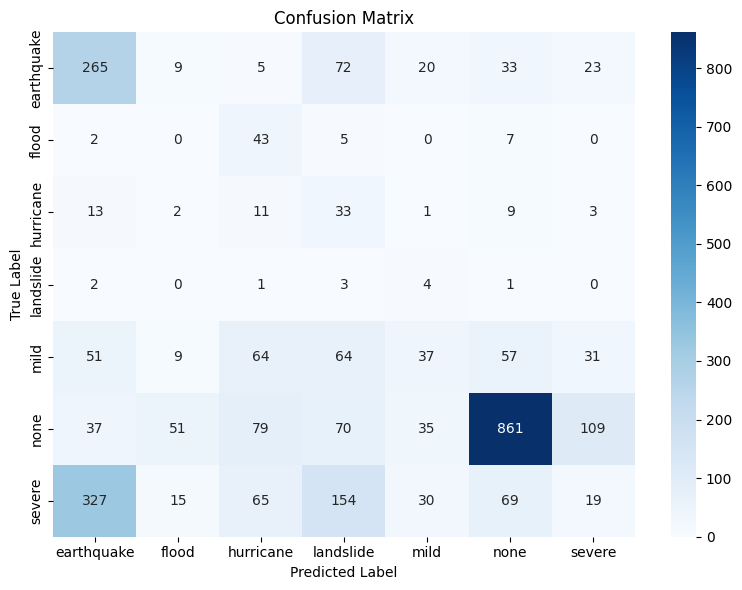

✅ Confusion matrix saved as confusion_matrix.png and displayed.


In [33]:
# eval.py

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print('entered eval file')

# --- Configuration ---
NUM_CLASSES = 7   # your model was trained on 7 classes
BATCH_SIZE = 32
NUM_WORKERS = 2
DATA_DIR = "/content/drive/MyDrive/disaster_classification/reorganized/dev"
MODEL_PATH = "saved_models/model_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data ---
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dev_dataset = datasets.ImageFolder(DATA_DIR, data_transforms)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Loaded {len(dev_dataset)} images for evaluation.")
print(f"Class labels: {dev_dataset.classes}")

# --- Model ---
model = models.resnet18(weights=None)  # no pretrained
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

state = torch.load(MODEL_PATH, map_location=device)
if "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)

print(f"Model loaded successfully from {MODEL_PATH}")

model.to(device)
model.eval()

# --- Evaluation ---
all_preds, all_labels = [], []
print("Starting evaluation...")
with torch.no_grad():
    for i, (imgs, labels) in enumerate(dev_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{len(dev_loader)} batches...")

print("\n✅ Evaluation Complete!")

# --- Metrics ---
target_names = dev_dataset.classes

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=target_names))

# Save classification report as CSV
report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv", index=True)
print("✅ Classification report saved as classification_report.csv")

# Macro F1
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1 Score:", macro_f1)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=target_names,
    yticklabels=target_names,
    cmap="Blues"
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

# Save + Show
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

print("✅ Confusion matrix saved as confusion_matrix.png and displayed.")


In [ ]:
from flask_ngrok import run_with_ngrok
run_with_ngrok(app)  # starts ngrok when you run app.run()


In [25]:
%%writefile app.py
#!/usr/bin/env python3
"""
app.py - Minimal but robust Flask app for image classification with PyTorch (ResNet18).
Features:
 - robust checkpoint loading (many formats)
 - auto-detect num classes and label mapping if saved in checkpoint
 - CPU/GPU aware
 - single-image upload (+ simple HTML UI) and batch upload endpoints
 - returns top-k predictions with probabilities
 - saves outputs/logs to outputs/
"""

import os
import io
import sys
import time
import json
import logging
from pathlib import Path
from typing import List, Tuple, Dict

from flask import Flask, request, jsonify, render_template_string, send_file
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

# ---------------------------
# Configuration
# ---------------------------
# Default locations to try for model file (will pick first existing)
MODEL_CANDIDATES = [
    os.environ.get("MODEL_PATH", ""),  # allow override
    "/content/drive/MyDrive/disaster_classification_project/saved_models/model_best.pth",
    "saved_models/model_best.pth",
    "saved_models/best_model.pth",
    "/content/drive/MyDrive/disaster_classification/saved_models/model_best.pth",
    "/content/drive/MyDrive/disaster_classification/model_best.pth",
    "/content/drive/MyDrive/disaster_classification_project/saved_models/model_best.pth",
    "/content/drive/MyDrive/disaster_classification/reorganized/saved_models/model_best.pth",
]
MODEL_CANDIDATES = [p for p in MODEL_CANDIDATES if p]

# runtime config
MAX_CONTENT_LENGTH = 16 * 1024 * 1024  # 16 MB upload limit
TOP_K_DEFAULT = 3
OUTPUTS_DIR = "outputs"
os.makedirs(OUTPUTS_DIR, exist_ok=True)

# default class names fallback if checkpoint doesn't contain them
FALLBACK_CLASS_NAMES = ['earthquake','flood','hurricane','landslide','mild','none','severe']

# set up logging
logger = logging.getLogger("app")
logger.setLevel(logging.INFO)
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(logging.Formatter("%(asctime)s %(levelname)s: %(message)s"))
logger.addHandler(ch)

# ---------------------------
# Utilities
# ---------------------------
def find_model_path() -> str:
    for p in MODEL_CANDIDATES:
        if p and os.path.exists(p):
            logger.info(f"Using model file: {p}")
            return p
    raise FileNotFoundError(f"No model found in candidates: {MODEL_CANDIDATES}")

def load_checkpoint(path: str, map_location="cpu"):
    """Load checkpoint, return raw object from torch.load"""
    logger.info(f"Loading checkpoint from {path} ...")
    ckpt = torch.load(path, map_location=map_location)
    logger.info("Checkpoint loaded.")
    return ckpt

def extract_state_and_labels(ckpt) -> Tuple[dict, List[str]]:
    """
    Accepts many checkpoint shapes:
      - {'model_state': state_dict, ...}
      - {'model_state_dict': state_dict, ...}
      - raw state_dict itself
      - may contain 'idx_to_label' or 'label_to_idx'
    Returns (state_dict, class_names_list_or_None)
    """
    state = None
    class_names = None

    if isinstance(ckpt, dict):
        # look for common keys
        for key in ["model_state", "state_dict", "model_state_dict", "model"]:
            if key in ckpt:
                state = ckpt[key]
                break
        # Sometimes state dict is top-level (keys like 'fc.weight'), handle below
        # label mappings
        if "idx_to_label" in ckpt:
            idx_map = ckpt["idx_to_label"]
            # idx_to_label might be dict or list
            if isinstance(idx_map, dict):
                # convert dict to list ordered by index
                try:
                    class_names = [idx_map[str(i)] if str(i) in idx_map else idx_map[i] for i in range(len(idx_map))]
                except Exception:
                    class_names = [idx_map[k] for k in sorted(idx_map.keys())]
            elif isinstance(idx_map, list):
                class_names = idx_map
        elif "label_to_idx" in ckpt:
            l2i = ckpt["label_to_idx"]
            try:
                # invert
                inv = {v:k for k,v in l2i.items()}
                class_names = [inv[i] for i in range(len(inv))]
            except Exception:
                # best effort
                class_names = list(l2i.keys())
    # if state still None and ckpt looks like raw state_dict (keys include 'fc.weight')
    if state is None:
        # assume ckpt is raw state_dict (mapping of param names -> tensors)
        if isinstance(ckpt, dict) and any(k.endswith("fc.weight") or "fc.weight" in k for k in ckpt.keys()):
            state = ckpt
    return state, class_names

def infer_num_classes_from_state(state: dict) -> int:
    """Try to infer number of classes from state dict by looking at fc.weight shape"""
    for candidate in ["fc.weight", "classifier.weight", "head.weight"]:
        if candidate in state:
            return int(state[candidate].shape[0])
    # look for any weight that endswith 'fc.weight'
    for k in state.keys():
        if k.endswith("fc.weight"):
            return int(state[k].shape[0])
    # fallback None -> caller must handle
    return None

def build_model(num_classes: int):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ---------------------------
# Load model once at startup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

try:
    MODEL_PATH = find_model_path()
except FileNotFoundError as e:
    logger.error(str(e))
    MODEL_PATH = None

model = None
class_names = None

if MODEL_PATH:
    try:
        raw_ckpt = load_checkpoint(MODEL_PATH, map_location=device)
        state_dict, ckpt_class_names = extract_state_and_labels(raw_ckpt)
        inferred_num = None
        if state_dict is not None:
            inferred_num = infer_num_classes_from_state(state_dict)
        if ckpt_class_names:
            class_names = list(ckpt_class_names)
            num_classes = len(class_names)
        elif inferred_num:
            num_classes = int(inferred_num)
        else:
            # fallback
            class_names = FALLBACK_CLASS_NAMES
            num_classes = len(class_names)
        # build model and load weights (partial load if necessary)
        logger.info(f"Building ResNet18 with num_classes={num_classes}")
        model = build_model(num_classes)
        model_state = state_dict if state_dict is not None else raw_ckpt
        # filter state to matching shapes where possible to avoid fc mismatch crashes
        model_sd = model.state_dict()
        filtered_state = {}
        for k, v in model_state.items():
            if k in model_sd and model_sd[k].shape == v.shape:
                filtered_state[k] = v
            else:
                # skip mismatched param (e.g., fc.weight shape mismatch)
                logger.debug(f"Skipping param (missing/mismatch): {k}")
        model.load_state_dict(filtered_state, strict=False)
        logger.info("Model weights loaded (partial=True where needed).")
        if class_names is None:
            # if checkpoint had no class names, but it contained label_to_idx we tried earlier.
            class_names = FALLBACK_CLASS_NAMES[:num_classes]  # trim to num_classes
    except Exception as ex:
        logger.exception("Error loading model; continuing with randomly initialized model.")
        # fallback: create random model with fallback num classes
        if 'num_classes' not in locals():
            num_classes = len(FALLBACK_CLASS_NAMES)
        model = build_model(num_classes)
        class_names = FALLBACK_CLASS_NAMES[:num_classes]

# move model to device and eval
if model is None:
    num_classes = len(FALLBACK_CLASS_NAMES)
    model = build_model(num_classes)
    class_names = FALLBACK_CLASS_NAMES[:num_classes]

model.to(device)
model.eval()
logger.info(f"Model ready. Class names: {class_names}")

# Preprocessing transform
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ---------------------------
# Inference helpers
# ---------------------------
def read_image(stream) -> Image.Image:
    try:
        img = Image.open(stream).convert("RGB")
        return img
    except Exception:
        raise

def predict_image(img: Image.Image, top_k: int = 3) -> List[Dict]:
    model_input = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(model_input)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    # get topk
    topk = min(top_k, len(probs))
    indices = probs.argsort()[::-1][:topk]
    results = []
    for idx in indices:
        results.append({"label": class_names[int(idx)], "index": int(idx), "prob": float(probs[int(idx)])})
    return results

# ---------------------------
# Flask app
# ---------------------------
app = Flask(__name__)
app.config["MAX_CONTENT_LENGTH"] = MAX_CONTENT_LENGTH

# simple HTML UI for quick test
HTML_TEMPLATE = """
<!doctype html>
<title>Disaster Classification</title>
<h1>Upload an image to classify</h1>
<form action="/predict" method="post" enctype="multipart/form-data">
  <input type=file name=file>
  <input type=submit value="Upload">
</form>
<p>Use POST /predict (form-data key 'file') for JSON response.</p>
"""

@app.route("/", methods=["GET"])
def index():
    return render_template_string(HTML_TEMPLATE)

@app.route("/health", methods=["GET"])
def health():
    return jsonify({"status": "ok", "device": str(device), "model_loaded": bool(model is not None), "num_classes": len(class_names)})

@app.route("/predict", methods=["POST"])
def predict():
    # Accept single file upload
    if "file" not in request.files:
        return jsonify({"error": "No file part. Use form key 'file'."}), 400
    file = request.files["file"]
    if file.filename == "":
        return jsonify({"error": "Empty filename."}), 400
    try:
        img = read_image(file.stream)
    except Exception:
        return jsonify({"error": "Unable to read image."}), 400
    top_k = int(request.form.get("top_k", TOP_K_DEFAULT))
    try:
        results = predict_image(img, top_k=top_k)
    except Exception as e:
        logger.exception("Inference error")
        return jsonify({"error": "Inference failed", "details": str(e)}), 500

    # Save a small output record
    try:
        now = int(time.time())
        out_json = {"time": now, "results": results}
        out_path = os.path.join(OUTPUTS_DIR, f"pred_{now}.json")
        with open(out_path, "w") as f:
            json.dump(out_json, f)
    except Exception:
        logger.exception("Failed to save output")

    return jsonify({"predictions": results})

@app.route("/predict_batch", methods=["POST"])
def predict_batch():
    # Accept multiple files under 'files'
    files = request.files.getlist("files")
    if not files:
        return jsonify({"error": "No files uploaded. Use form key 'files' multiple times."}), 400
    top_k = int(request.form.get("top_k", TOP_K_DEFAULT))
    responses = []
    for file in files:
        try:
            img = read_image(file.stream)
            res = predict_image(img, top_k=top_k)
            responses.append({"filename": file.filename, "predictions": res})
        except Exception as e:
            responses.append({"filename": file.filename, "error": str(e)})
    return jsonify({"results": responses})

@app.route("/classes", methods=["GET"])
def classes():
    return jsonify({"classes": class_names})

@app.route("/download/<path:fname>", methods=["GET"])
def download(fname):
    # download outputs saved in outputs folder
    safe = os.path.join(OUTPUTS_DIR, os.path.basename(fname))
    if os.path.exists(safe):
        return send_file(safe, as_attachment=True)
    return jsonify({"error": "file not found"}), 404

# ---------------------------
# CLI / Run
# ---------------------------
if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    host = "0.0.0.0"
    logger.info(f"Starting Flask app on {host}:{port} ...")
    # Run with threaded server for simplicity; production use gunicorn or uvicorn if using ASGI
    app.run(host=host, port=port, threaded=True)


Overwriting app.py


In [ ]:
!python app.py



2025-09-14 17:07:47,746 INFO: Using device: cpu
2025-09-14 17:07:47,821 INFO: Using model file: /content/drive/MyDrive/disaster_classification_project/saved_models/model_best.pth
2025-09-14 17:07:47,821 INFO: Loading checkpoint from /content/drive/MyDrive/disaster_classification_project/saved_models/model_best.pth ...
2025-09-14 17:07:52,218 INFO: Checkpoint loaded.
2025-09-14 17:07:52,219 INFO: Building ResNet18 with num_classes=7
2025-09-14 17:07:52,416 INFO: Model weights loaded (partial=True where needed).
2025-09-14 17:07:52,417 INFO: Model ready. Class names: ['earthquake', 'flood', 'hurricane', 'landslide', 'mild', 'none', 'severe']
2025-09-14 17:07:52,421 INFO: Starting Flask app on 0.0.0.0:5000 ...
 * Serving Flask app 'app'
 * Debug mode: off
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
Press CTRL+C to quit
